In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from scipy.optimize import curve_fit
from scipy.interpolate import interp2d
from astropy import  convolution

import scipy.ndimage as scipynd
import scipy.stats as stats
import scipy.linalg
from scipy.stats import chisquare
import numpy.polynomial.polynomial as poly
from mpl_toolkits.mplot3d import axes3d

%load_ext autoreload
%autoreload 2

import functions as fn
import calculations as calc
import spectrum_functions as spec_fn

DEIMOS_DATA = '/Users/taracampbell/thesis/'

In [2]:
%reload_ext autoreload

In [3]:
plt.rcParams['figure.figsize'] = [20, 8]

In [4]:
%load_ext autotime

In [5]:
# Read in science files

path1 = DEIMOS_DATA + '/dra1_exp2/*.dat'
files1 = glob.glob(path1)
folder1 = fn.read_sci_files(files1)

# Read in sky line wavelengths
skylinefile = DEIMOS_DATA + '/skylines_air.data'
sky_lines = pd.read_csv(skylinefile, sep='\s+')

wavel = sky_lines['Wave']

time: 1.36 s


In [6]:
# Load in telluric spectra

path_tellurics = DEIMOS_DATA + '/tellurics2/*.dat'
tellurics = glob.glob(path_tellurics)

tel_spectra = fn.read_tel_files(tellurics)

time: 4.12 s


In [7]:
# get all O2 and H2O values from tellurics
o2s = []
h2os = []
for tfile in tellurics:
    o2, h2o = fn.parse_tfile(tfile)
    o2s.append(o2)
    h2os.append(h2o)
    
unique_os = list(set(o2s))
unique_h2os = list(set(h2os))

unique_os.sort()
unique_h2os.sort()

# create the overlaying O2 and H2O array
O2, H2O = np.meshgrid(unique_os, unique_h2os)

time: 2.22 ms


In [8]:
# get the kernel means of folder 1
folder1_kernel_means = calc.kernel_widths(files1, wavel)

/Users/taracampbell/Thesis/calculations.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauss_range['WAVE'] -= sline
/Users/taracampbell/Thesis/calculations.py:149: RuntimeWarning: invalid value encountered in sqrt
  param_err = np.sqrt(np.diag(pcov))
/Users/taracampbell/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


time: 51.7 s


# One Slit - Folder 1

In [9]:
plt.rcParams.update({'font.size': 15})

time: 947 µs


The Lowest Chi Squared Values is: 33.064998
The O2 Value is: 1.450505
The H2O Value is: 52.474747
The telluric correction is: 0.025000


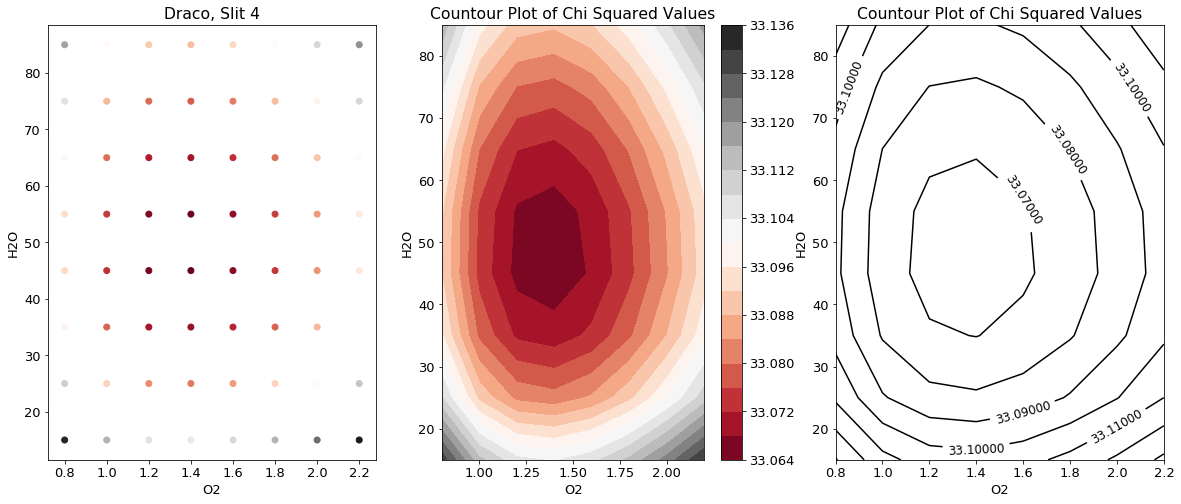

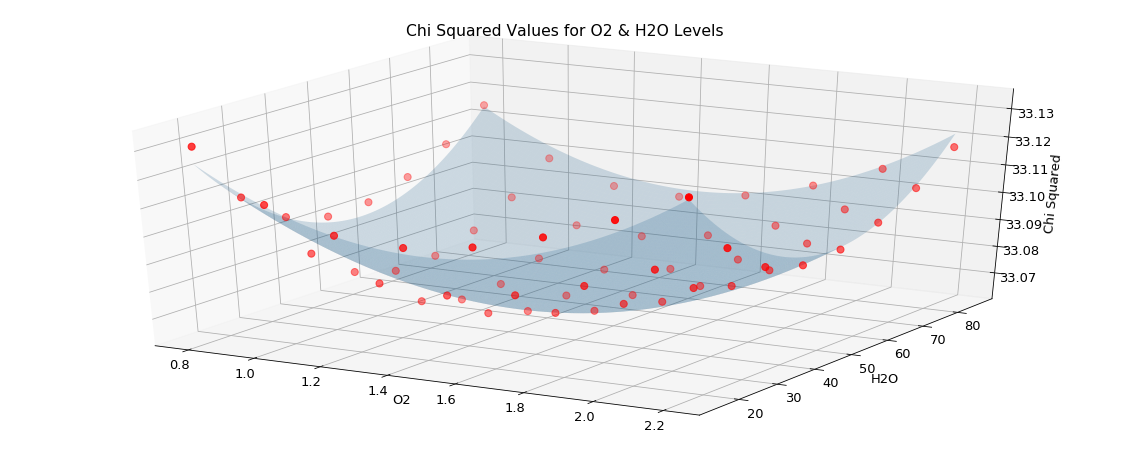

time: 19.3 s


In [18]:
wrange = np.arange(-0.25,0.25,0.025)

_h2o_array = []
_o2_array = []
_min_chi2_array = []
_SNs = []
_tel_correct = []

i = 4
use_waves, use_fluxes, use_ivar = fn.filter_error(folder1[i])

# MAKE AN IF / PASS STATEMENT HERE IN CASE THERE AREN'T ENOUGH GOOD POINTS
if len(use_waves) < 5000:
    pass

else:

    chi2_array = []
    for tfile in tellurics:
        o2, h2o = fn.parse_tfile(tfile)
        onechi2 = spec_fn.RunOneTelluric_Full(tfile, i, use_waves, use_fluxes, folder1_kernel_means)

        chi2_array.append([o2,h2o,onechi2])

    # initialize our empty array that we will be putting our values into
    w, h = 8, 8;
    big_array = [[0 for x in range(w)] for y in range(h)] 

    for a in chi2_array:
        o2 =  a[0]
        h2o = a[1]
        w_array = a[2]

        best_wshift = min(list(w_array))
        ind_w = np.where(w_array == best_wshift)
        tel_value = wrange[ind_w]
        _tel_correct.append(tel_value)

        o2_index = unique_os.index(o2)
        h2o_index = unique_h2os.index(h2o)

        big_array[h2o_index][o2_index] = best_wshift
    
    big_array = np.array(big_array)
    
    
    # Find the O2 and H2O values of lowest chi squared statistics via fitting a surface
    # big_array now has one value of value for chi squared after minimizing across this axis
        
    # flatten our 2D arrays
    
    O_vals = O2.flatten()
    H2O_vals = H2O.flatten()
    BA_vals = big_array.flatten()

    data = np.c_[O_vals,H2O_vals,BA_vals]

    # empty grid covering the domain of the data
    mn = np.min(data, axis=0)
    mx = np.max(data, axis=0)
    X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 100), np.linspace(mn[1], mx[1], 100))
    XX = X.flatten()
    YY = Y.flatten()

    # best-fit quadratic curve (2nd-order)
    A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
    C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

    # evaluate it on our grid
    Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

    # get the minimum chi squared and the corresponding O2 & H2O values
    value_indices = np.where(Z == np.min(Z))
    Z_min = np.min(Z)
    o2_value = X[value_indices][0]
    h2o_value = Y[value_indices][0]
    
    _h2o_array.append(h2o_value)
    _o2_array.append(o2_value)
    _min_chi2_array.append(Z_min)

    # get the S/N of each spectrum
    mean_SN = np.mean(folder1[i]['S/N'])
    _SNs.append(mean_SN)
    
    print('The Lowest Chi Squared Values is: %f'%(Z_min))
    print('The O2 Value is: %f'%(o2_value))
    print('The H2O Value is: %f'%(h2o_value))
    print('The telluric correction is: %f'%(tel_value))

    plt.subplot(1, 3, 1)
    plt.scatter(O2, H2O, c=big_array, cmap='RdGy')
    plt.title("Draco, Slit %.0f" %(i))
    plt.xlabel('O2')
    plt.ylabel('H2O')

    plt.subplot(1, 3, 2)
    cpf = plt.contourf(O2, H2O, big_array, 20, cmap='RdGy')
    colors = ['w' if level<0 else 'k' for level in cpf.levels]
    plt.title('Countour Plot of Chi Squared Values')
    plt.xlabel('O2')
    plt.ylabel('H2O')
    plt.colorbar();

    plt.subplot(1, 3, 3)
    cp = plt.contour(O2, H2O, big_array, colors= colors)
    plt.clabel(cp, fmt='%.5f', fontsize=12, colors=colors)
    plt.title('Countour Plot of Chi Squared Values')
    plt.xlabel('O2')
    plt.ylabel('H2O');

    plt.show()
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
    ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
    plt.xlabel('O2')
    plt.ylabel('\nH2O')
    plt.title('Chi Squared Values for O2 & H2O Levels')
    ax.set_zlabel('Chi Squared')
    ax.axis('tight')

    plt.show()

In [19]:
plt.rcParams.update({'font.size': 13})

time: 833 µs


In [20]:
# calc index of min/max Z value
big_array = np.array(big_array)

omin, hmin = np.unravel_index(np.argmin(big_array), big_array.shape)
mi = (O2[omin, hmin], H2O[omin, hmin], big_array.min())

time: 1.3 ms


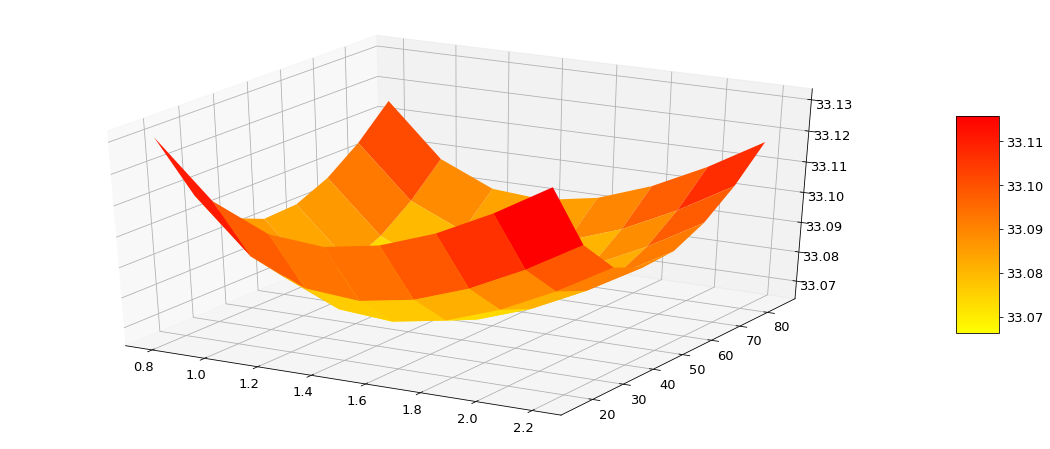

time: 224 ms


In [21]:
# lets try to make a surface
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(O2, H2O, big_array, cmap="autumn_r", lw=0.5, rstride=1, cstride=1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

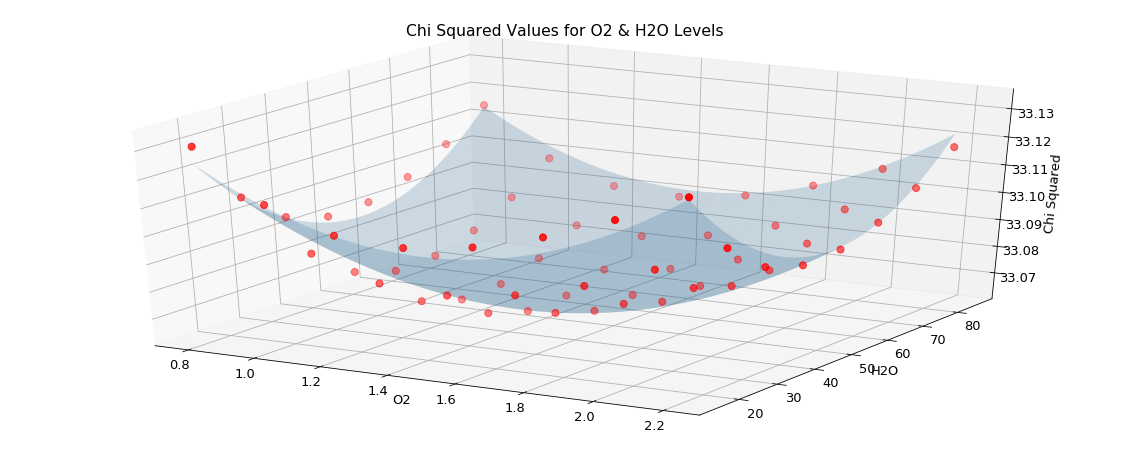

time: 2.06 s


In [22]:
# using this: http://inversionlabs.com/2016/03/21/best-fit-surfaces-for-3-dimensional-data.html

# flatten our 2D arrays
O_vals = O2.flatten()
H2O_vals = H2O.flatten()
BA_vals = big_array.flatten()

data = np.c_[O_vals,H2O_vals,BA_vals]

# regular grid covering the domain of the data
mn = np.min(data, axis=0)
mx = np.max(data, axis=0)
X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 100), np.linspace(mn[1], mx[1], 100))
XX = X.flatten()
YY = Y.flatten()

# best-fit quadratic curve (2nd-order)
A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])
    
# evaluate it on a grid, Z is our 2D polynomials
Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)

# plot points and fitted surface using Matplotlib
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
plt.xlabel('O2')
plt.ylabel('H2O')
plt.title('Chi Squared Values for O2 & H2O Levels')
ax.set_zlabel('Chi Squared')
ax.axis('tight')

plt.show()

In [23]:
value_indices = np.where(Z == np.min(Z))
Z_min = np.min(Z)
o2_value = X[value_indices][0]
h2o_value = Y[value_indices][0]

time: 2.48 ms


In [24]:
# values with fitting a surface
Z_min, o2_value, h2o_value

(33.06499840042643, 1.4505050505050505, 52.474747474747474)

time: 2.29 ms


In [25]:
# values with interpolation
min_chi_interp, o2_value_interp, h2o_value_interp

NameError: name 'min_chi_interp' is not defined

time: 29.6 ms


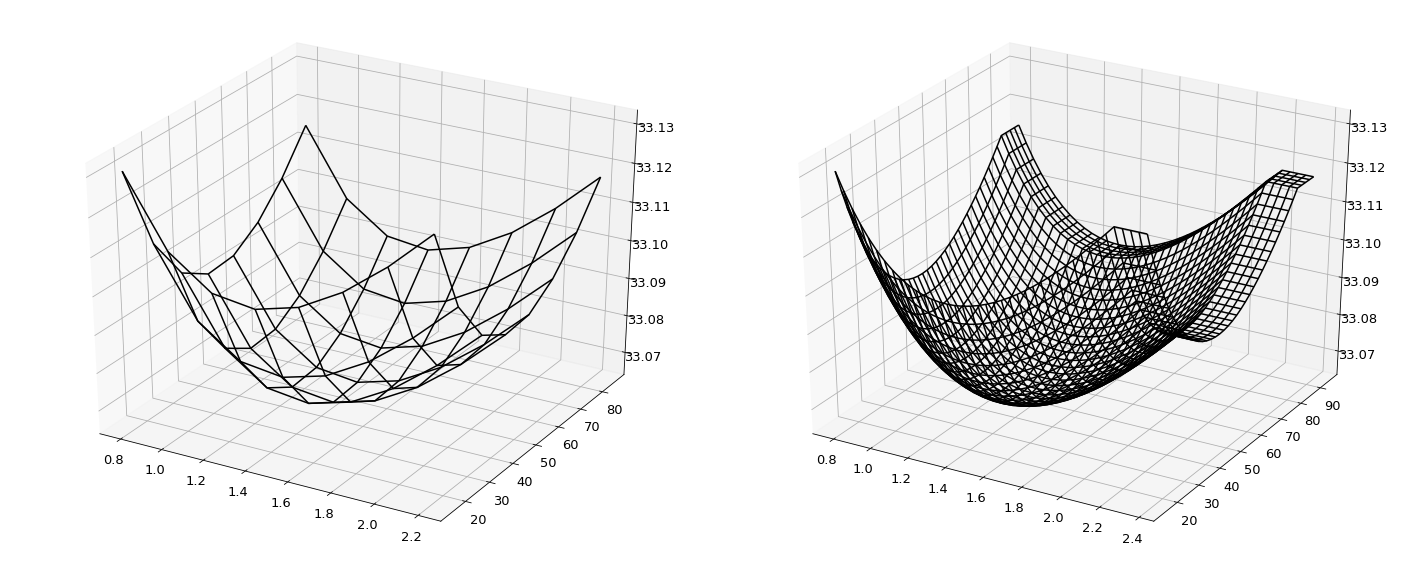

time: 339 ms


In [26]:
# lets try this
# from: https://scipython.com/book/chapter-8-scipy/examples/two-dimensional-interpolation-with-scipyinterpolaterectbivariatespline/
# yay this works

from scipy.interpolate import RectBivariateSpline
o2  = np.arange(0.8, 2.4,0.2)
h2o = np.arange(15,95,10)

interp_spline = RectBivariateSpline(h2o, o2, big_array)
o2_n = np.arange(0.8, 2.4,0.04)
h2o_n = np.arange(15,95,2)
O2_n, H2O_n = np.meshgrid(o2_n,h2o_n)
big_array_n = interp_spline(h2o_n, o2_n)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
ax[0].plot_wireframe(O2, H2O, big_array, color='k')

ax[1].plot_wireframe(O2_n, H2O_n, big_array_n, color='k')

fig.tight_layout()
plt.show()

In [27]:
minimum_indices = np.where(big_array_n == np.min(big_array_n))
min_chi_interp = np.min(big_array)

h2o_ind = minimum_indices[0][0]
o2_ind = minimum_indices[1][0]

time: 1.63 ms


In [28]:
h2o_value_interp = h2o_n[h2o_ind]
o2_value_interp = o2_n[o2_ind]

time: 940 µs


In [29]:
o2_value_interp, h2o_value_interp, min_chi_interp

(1.3600000000000005, 49, 33.06529788683402)

time: 2.78 ms


# FINAL METHOD

In [18]:
# initialize arrays in order to create the plot of S/N v. H2O, O2 

h2o_array = []
o2_array = []
min_chi2_array = []
SNs = []
tel_correct = []

for i in range(len(folder1)):
    # filter points with large error
    use_waves, use_fluxes, use_ivar = fn.filter_error(folder1[i])
    
    # MAKE AN IF / PASS STATEMENT HERE IN CASE THERE AREN'T ENOUGH GOOD POINTS
    if len(use_waves) < 5000:
        pass
    
    else:

        chi2_array = []
        for tfile in tellurics:
            o2, h2o = fn.parse_tfile(tfile)
            onechi2 = spec_fn.RunOneTelluric_Full(tfile, i, use_waves, use_fluxes, folder1_kernel_means)

            chi2_array.append([o2,h2o,onechi2])

        # initialize our empty array that we will be putting our values into
        w, h = 8, 8;
        big_array = [[0 for x in range(w)] for y in range(h)] 

        for a in chi2_array:
            o2 =  a[0]
            h2o = a[1]
            w_array = a[2]
            
            # minimize over 
            best_wshift = min(list(w_array))
            ind_w = np.where(w_array == best_wshift)
            tel_value = wrange[ind_w]
            tel_correct.append(tel_value)

            o2_index = unique_os.index(o2)
            h2o_index = unique_h2os.index(h2o)

            big_array[h2o_index][o2_index] = best_wshift

        # Find the indices of lowest chi squared via fitting a surface
        
        # flatten our 2D arrays
        big_array = np.array(big_array)
        O_vals = O2.flatten()
        H2O_vals = H2O.flatten()
        BA_vals = big_array.flatten()

        data = np.c_[O_vals,H2O_vals,BA_vals]

        # regular grid covering the domain of the data
        mn = np.min(data, axis=0)
        mx = np.max(data, axis=0)
        X,Y = np.meshgrid(np.linspace(mn[0], mx[0], 100), np.linspace(mn[1], mx[1], 100))
        XX = X.flatten()
        YY = Y.flatten()

        # best-fit quadratic curve (2nd-order)
        A = np.c_[np.ones(data.shape[0]), data[:,:2], np.prod(data[:,:2], axis=1), data[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, data[:,2])

        # evaluate it on a grid
        Z = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(X.shape)
        
        # get the minimum X^2 and the corresponding O2 & H2O values
        value_indices = np.where(Z == np.min(Z))
        Z_min = np.min(Z)
        o2_value = X[value_indices][0]
        h2o_value = Y[value_indices][0]
        
        h2o_array.append(h2o_value)
        o2_array.append(o2_value)
        min_chi2_array.append(Z_min)

        # get the S/N of each spectrum
        mean_SN = np.mean(folder1[i]['S/N'])
        SNs.append(mean_SN)
        
        #keep track
        print('Slit %f' %(i))
        
#         plt.subplot(1, 4, 1)
#         plt.scatter(O2, H2O, c=big_array, cmap='RdGy')
#         plt.title("High SN Slit %.0f" %(i))
#         plt.xlabel('O2')
#         plt.ylabel('H2O')

#         plt.subplot(1, 4, 2)
#         cpf = plt.contourf(O2, H2O, big_array, 20, cmap='RdGy')
#         colors = ['w' if level<0 else 'k' for level in cpf.levels]
#         plt.title('Countour Plot of Chi Squared Values')
#         plt.xlabel('O2')
#         plt.ylabel('H2O')
#         plt.colorbar();

#         plt.subplot(1, 4, 3)
#         cp = plt.contour(O2, H2O, big_array, colors= colors)
#         plt.clabel(cp, fmt='%.5f', fontsize=12, colors=colors)
#         plt.title('Countour Plot of Chi Squared Values')
#         plt.xlabel('O2')
#         plt.ylabel('H2O')
#         fig = plt.figure()

#         ax = fig.gca(projection='3d')
#         ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2)
#         ax.scatter(data[:,0], data[:,1], data[:,2], c='r', s=50)
#         plt.xlabel('O2')
#         plt.ylabel('H2O')
#         plt.title('Chi Squared Values for O2 & H2O Levels')
#         ax.set_zlabel('Chi Squared')
#         ax.axis('tight');

#         plt.show()

Slit 0.000000
Slit 1.000000
Slit 2.000000
Slit 3.000000
Slit 4.000000
Slit 5.000000
Slit 6.000000
Slit 7.000000
Slit 8.000000
Slit 9.000000
Slit 10.000000
Slit 11.000000
Slit 12.000000
Slit 13.000000
Slit 14.000000
Slit 16.000000
Slit 17.000000
Slit 18.000000
Slit 19.000000
Slit 20.000000
Slit 22.000000
Slit 24.000000
Slit 25.000000
Slit 26.000000
Slit 27.000000
Slit 28.000000
Slit 29.000000
Slit 30.000000
Slit 31.000000
Slit 32.000000
Slit 33.000000
Slit 34.000000
Slit 35.000000
Slit 36.000000
Slit 37.000000
Slit 38.000000
Slit 40.000000
Slit 42.000000
Slit 43.000000
Slit 45.000000
Slit 47.000000
Slit 48.000000
Slit 49.000000
Slit 50.000000
Slit 51.000000
Slit 52.000000
Slit 53.000000
Slit 54.000000
Slit 55.000000
Slit 56.000000
Slit 58.000000
Slit 59.000000
Slit 60.000000
Slit 61.000000
Slit 62.000000
Slit 64.000000
Slit 65.000000
Slit 66.000000
Slit 67.000000
Slit 68.000000
Slit 69.000000
Slit 70.000000
Slit 71.000000
Slit 72.000000
Slit 73.000000
Slit 74.000000
Slit 75.000000
Slit 

In [19]:
SNs = np.array(SNs)
h2o_array = np.array(h2o_array)
o2_array = np.array(o2_array)

SN_ind = np.where(SNs > 10)
SN_h2o = h2o_array[[SN_ind][0]]
SN_o2 = o2_array[SN_ind][0]

time: 1.79 ms


In [33]:
plt.rcParams['figure.figsize'] = [8, 8]

time: 952 µs


Text(0, 0.5, 'H2O')

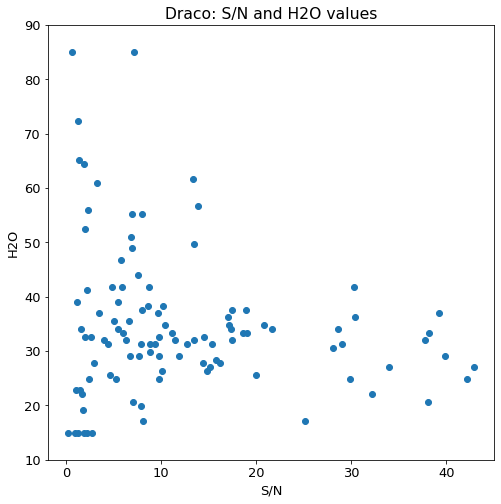

time: 161 ms


In [34]:
plt.scatter(SNs, h2o_array)
plt.title('Draco: S/N and H2O values')
plt.xlabel('S/N')
plt.ylim(10,90)
plt.ylabel('H2O')

In [39]:
plt.rcParams.update({'font.size': 15})

time: 868 µs


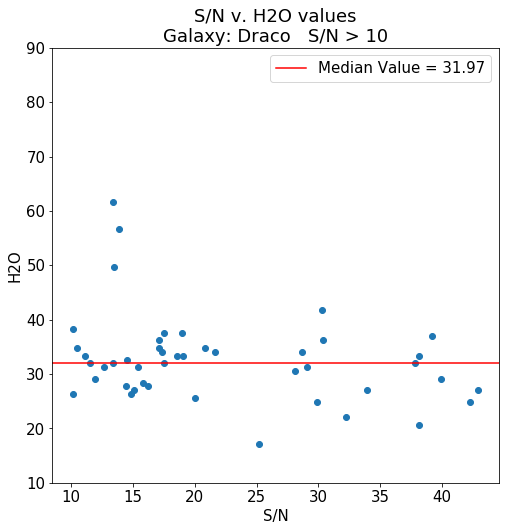

time: 228 ms


In [41]:
plt.scatter(SNs[SN_ind], h2o_array[[SN_ind][0]])
plt.title('S/N v. H2O values\nGalaxy: Draco   S/N > 10')
plt.xlabel('S/N')
plt.axhline(np.median(h2o_array[[SN_ind][0]]), color='red', label='Median Value = 31.97')
plt.ylabel('H2O')
plt.ylim(10,90)
plt.savefig('draco_h2o.png')
plt.legend()

In [22]:
np.std(h2o_array)

13.449724956551561

time: 2.48 ms


In [23]:
np.median(h2o_array[[SN_ind][0]])

31.96969696969697

time: 2.6 ms


In [24]:
np.mean(h2o_array)

34.72390572390573

time: 2 ms


In [25]:
np.var(h2o_array)

180.8951014068859

time: 2.16 ms


Text(0, 0.5, 'O2')

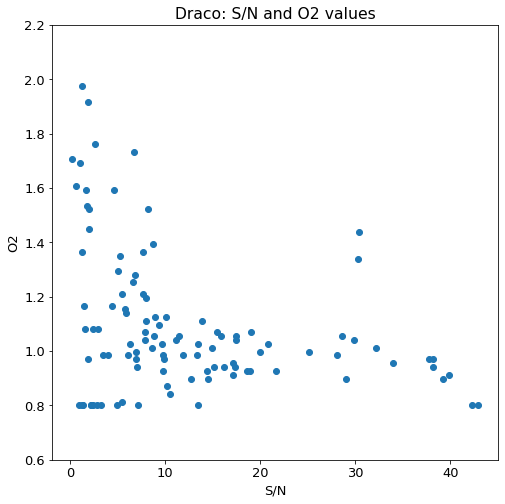

time: 199 ms


In [36]:
plt.scatter(SNs, o2_array)
plt.title('Draco: S/N and O2 values')
plt.xlabel('S/N')
#plt.axhline(np.median(o2_array[[SN_ind][0]]))
plt.ylim(0.6,2.2)
plt.ylabel('O2')

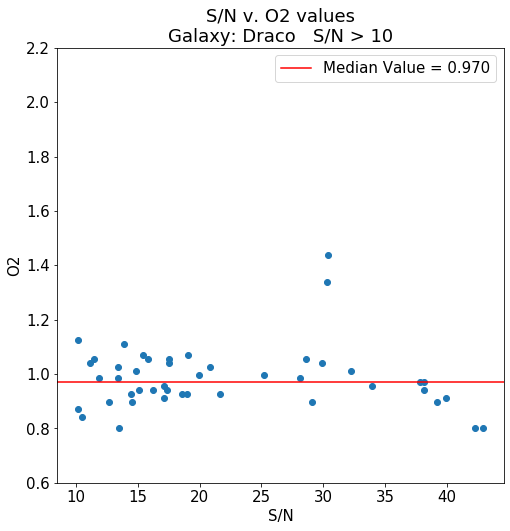

time: 232 ms


In [42]:
plt.scatter(SNs[SN_ind], o2_array[[SN_ind][0]])
plt.title('S/N v. O2 values\nGalaxy: Draco   S/N > 10')
plt.xlabel('S/N')
plt.axhline(np.median(o2_array[[SN_ind][0]]), color='red', label = 'Median Value = 0.970')
plt.ylabel('O2')
plt.ylim(0.6,2.2)
plt.savefig('draco_o2.png')
plt.legend()

In [35]:
np.median(o2_array[[SN_ind][0]])

0.9696969696969697

time: 3.12 ms


In [45]:
tel_correct = np.array(tel_correct)
len(tel_correct[SN_ind])

45

time: 4.74 ms


Text(0.5, 1.0, 'S/N and Telluric Correction for S/N > 10')

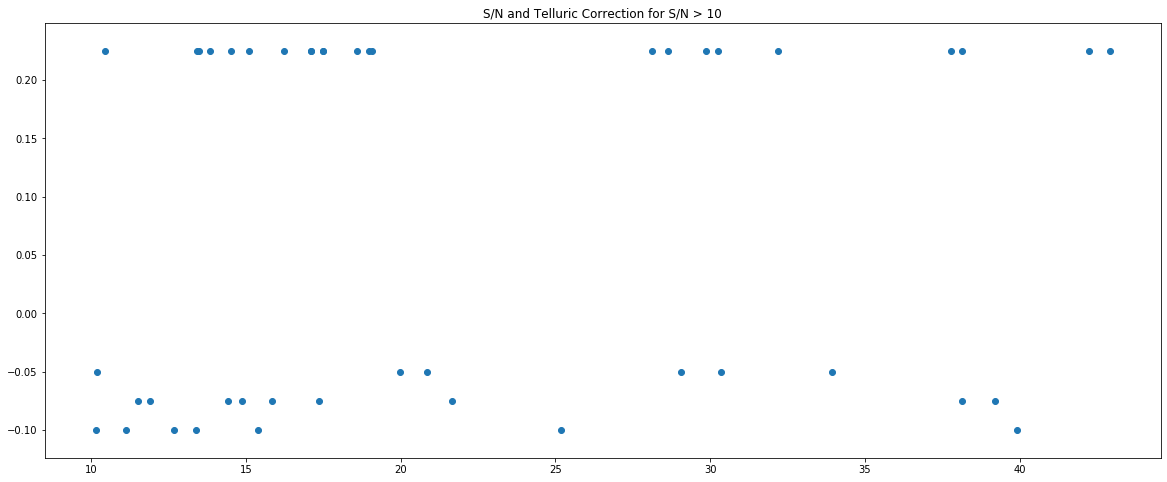

time: 195 ms


In [50]:
plt.scatter(SNs[SN_ind], tel_correct[SN_ind])
plt.title('S/N and Telluric Correction for S/N > 10')